In [2]:
# introducing new features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Set PYTHONHASHSEED to prevent hash randomization
os.environ['PYTHONHASHSEED'] = '12345'

In [3]:
# import
# plotting inline
%matplotlib inline

# working directory
import sys
sys.path.append('../src')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [4]:
pd.set_option('display.max_rows', 1000)
import sys
sys.setrecursionlimit(10000)

In [5]:
from onlinelogisticregression import ( 
    ThompsonSamplingPolicy,
    GreedyPolicy,
    UCBPolicy,
    RandomPolicy,
)

In [79]:
experiment_params_name = [
"nArms",    "nPerRound",  "nRounds",    "nFeatures",    "lambda",   "alpha",    "nSims",    "seed"
]
experiment_params_nums = [
# [2,          100,         100,          2,              0.1,        1,          10,         66],
# [10,         100,         100,          2,              0.1,        1,          10,         66],
# [10,         100,         100,          3,              0.1,        1,          10,         66],
# [10,         100,         100,          3,              0.1,        10,         10,         66],
# [10,         10,          100,          3,              0.1,        10,         10,         66],
# [2,          10,          100,          2,              0.1,        10,         100,        66],
# [2,          10,          100,          2,              0.1,        10,         10,         66],
[2,          10,         100,          2,              0.1,        10,         10,         66],

]
experiment_params_df = pd.DataFrame(experiment_params_nums, columns=experiment_params_name)
experiment_params_df

nArms  nPerRound  nRounds  nFeatures  lambda  alpha  nSims  seed
0      2         10      100          2     0.1     10     10    66

In [80]:
def round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, round_idx):
    round_df = pd.DataFrame({'k': [], 'x': [], 'reward': [], 'regret': [],
                            'true_weights': [], 'sample_weights': [], 
                            'mean_weights': [], 'std_weights': [],
                            'round': [],
                            'simul_id': [],
                            'policy': []})
                # generate data
    X = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim))
    
    for key, online_lr in dp_dict.items():
        print(key)    
        scores = online_lr.calculate_score(X)
        best_arms = online_lr.get_best_arm(scores)
        best_arm_features = online_lr.get_best_features(best_arms, X)
        rewards, _ = online_lr.get_reward(best_arm_features)
        regrets = online_lr.calculate_regret(X, best_arm_features)

        # log the data
        temp_df = pd.DataFrame({'k': best_arms, 'x': list(best_arm_features),
                                'reward': rewards, 'regret': regrets,
                                'true_weights': [online_lr.true_weights]*n_data_point_per_round,
                                'sample_weights': [online_lr.w]*n_data_point_per_round,
                                'mean_weights': [online_lr.m]*n_data_point_per_round,
                                'std_weights': [online_lr.q]*n_data_point_per_round,
                                'round':[round_idx]*n_data_point_per_round}, 
                                index=[round_idx]*n_data_point_per_round)

        # fit th e model
        online_lr.fit(best_arm_features, rewards)

        # append to round_df
        temp_df = temp_df.assign(simul_id = simulation, policy=key)

        round_df = pd.concat([round_df, temp_df])
    return round_df   

In [81]:
# # regret analysis
for param_index in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[param_index]
    print(f"Running simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    np.random.seed(seed)
    
    # do experiment
    experiment_df = pd.DataFrame()
    for simulation in range(n_sims):
        # instance of TS
        # params as dict:
        true_weights = np.random.uniform(-1, 1, n_dim)
        policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 'true_weights': true_weights}

        ts_lr = ThompsonSamplingPolicy(**policy_params)
        exploit_lr = GreedyPolicy(**policy_params)
        ucb_lr = UCBPolicy(**policy_params)
        random_lr = RandomPolicy(**policy_params)
        
        dp_dict = {'ts_lr': ts_lr, 
                'exploit_lr': exploit_lr,
                'ucb_lr': ucb_lr,
                # 'random_lr': random_lr
                }
        
        for i in range(n_rounds):
            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, i)

            experiment_df = pd.concat([experiment_df, round_df])

        # after finish all rounds
        # start introducing new features
        new_feature_true_weight = np.random.uniform(-1, 1, 1)
        for key, online_lr in dp_dict.items():
            online_lr.add_new_feature(new_feature_true_weight)

        for i in range(n_rounds, 2*n_rounds):
            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim+1, dp_dict, simulation, i)

            experiment_df = pd.concat([experiment_df, round_df])



    
    # save experiment_df to a file with the experiment parameters in the file name
    experiment_df.to_csv(f"../results_new_feature/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.csv", index=True)
    # also save it to a pickle file
    experiment_df.to_pickle(f"../results_new_feature/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")




Running simulation with 2 arms, 10 data points per round, 100 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50600D+03    |proj g|=  1.68452D+01

At iterate    1    f=  1.16318D+03    |proj g|=  1.48093D+01

At iterate    2    f=  2.98528D+01    |proj g|=  3.78862D+00

At iterate    3    f=  1.06781D+01    |proj g|=  1.53244D+00

exploit_lr
At iterate    4    f=  9.13321D+00    |proj g|=  1.24319D+00

At iterate    5    f=  6.59216D+00    |proj g|=  5.96565D-01

At iterate    6    f=  5.87062D+00    |proj g|=  4.83521D-01

At iterate    7    f=  5.66876D+00    |proj g|=  1.37779D-01

At iterate    8    f=  5.63843D+00    |proj g|=  2.38450D-02

At iterate    9    f=  5.63774D+00    |proj g|=  3.27777D-03

At iterate   10    f=  5.63773D+00    |proj g|=  3.22002D-05

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  4.28893D+00    |proj g|=  2.52862D-02

At iterate    2    f=  4.28891D+00    |proj g|=  9.22087D-03
ucb_lr

At iterate    3    f=  4.28890D+00    |proj g|=  8.97057D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   8.971D-08   4.289D+00
  F =   4.2889038962116315     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70784D+00    |proj g|=  3.76931D-01



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20098D+00    |proj g|=  4.69068D-01

At iterate    1    f=  5.19632D+00    |proj g|=  8.93383D-02

At iterate    2    f=  5.19612D+00    |proj g|=  1.66784D-02
ucb_lr

At iterate    3    f=  5.19612D+00    |proj g|=  5.69386D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.694D-08   5.196D+00
  F =   5.1961167265082286     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    4    f=  6.39768D+00    |proj g|=  4.80615D-04

At iterate    5    f=  6.39768D+00    |proj g|=  5.51151D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.512D-09   6.398D+00
  F =   6.3976756915384314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01609D+01    |proj g|=  1.47152D+01

At iterate    1    f=  4.63975D+00    |proj g|=  5.86138D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79034D+00    |proj g|=  5.42288D-01

At iterate    1    f=  4.78858D+00    |proj g|=  3.95617D-02

At iterate    2    f=  4.78857D+00    |proj g|=  2.39299D-02
ts_lr

At iterate    3    f=  4.78856D+00    |proj g|=  1.55025D-03

At iterate    4    f=  4.78856D+00    |proj g|=  5.18467D-05

At iterate    5    f=  4.78856D+00    |proj g|=  2.52547D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  6.02061D+00    |proj g|=  3.26787D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.268D-07   6.021D+00
  F =   6.0206146056233782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97641D+01    |proj g|=  1.22151D+01

At iterate    1    f=  9.48528D+00    |proj g|=  5.43748D+00
exploit_lr

At iterate    2    f=  7.19978D+00    |proj g|=  4.39775D-

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41083D+00    |proj g|=  6.95469D-01

At iterate    1    f=  5.40241D+00    |proj g|=  5.22546D-02

At iterate    2    f=  5.40235D+00    |proj g|=  1.38490D-02

At iterate    3    f=  5.40234D+00    |proj g|=  6.47003D-08
ucb_lr

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.470D-08   5.402D+00
  F =   5.4023444406886574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


exploit_lr
At iterate    1    f=  5.23432D+00    |proj g|=  4.50520D-02

At iterate    2    f=  5.23429D+00    |proj g|=  4.27828D-03

At iterate    3    f=  5.23429D+00    |proj g|=  5.60838D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.608D-09   5.234D+00
  F =   5.2342872414552861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84811D+00    |proj g|=  8.87804D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  4.31493D+00    |proj g|=  9.17793D-01

At iterate    3    f=  4.29418D+00    |proj g|=  3.87602D-01

At iterate    4    f=  4.29244D+00    |proj g|=  1.68130D-01

At iterate    5    f=  4.29207D+00    |proj g|=  9.99253D-04

At iterate    6    f=  4.29207D+00    |proj g|=  1.31974D-05

At iterate    7    f=  4.29207D+00    |proj g|=  3.16641D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.166D-07   4.292D+00
  F =   4.2920704411517763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
exploit_lr
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  6.06147D+00    |proj g|=  4.27675D-03
ts_lr

At iterate    4    f=  6.06147D+00    |proj g|=  1.94778D-03

At iterate    5    f=  6.06147D+00    |proj g|=  1.39399D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.394D-06   6.061D+00
  F =   6.0614699780987040     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66143D+00    |proj g|=  1.77017D+01

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  7.49399D+00    |proj g|=  3.96628D+00

At iterate    2    f=  6.73766D+00    |proj g|=  8.31000D-03
exploit_lr

At iterate    3    f=  6.73766D+00    |proj g|=  3.19932D-04

At iterate    4    f=  6.73766D+00    |proj g|=  2.03320D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   2.033D-07   6.738D+00
  F =   6.7376595015969754     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

exploit_lr
At iterate    2    f=  7.38411D+00    |proj g|=  4.07474D-02

At iterate    3    f=  7.38409D+00    |proj g|=  1.84243D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.842D-07   7.384D+00
  F =   7.3840923081426784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26790D+00    |proj g|=  5.39372D-01

At iterate    1    f=  5.26395D+00    |proj g|=  4.72941D-

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  6.23200D+00    |proj g|=  9.83180D-02

At iterate    3    f=  6.23131D+00    |proj g|=  1.36952D-01

At iterate    4    f=  6.23114D+00    |proj g|=  1.30923D-02

At iterate    5    f=  6.23113D+00    |proj g|=  1.73568D-05

At iterate    6    f=  6.23113D+00    |proj g|=  3.54282D-10
ucb_lr

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   3.543D-10   6.231D+00
  F =   6.2311271958345111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32514D+00    |proj g|=  1.33994D+01
exploit_lr

At iterate    1    f=  5.85061D+00    |proj g|=  5.12684D+00

At iterate    2    f=  5.42934D+00    |proj g|=  2.08804D+00

At iterate    3    f=  5.35065D+00    |proj g|=  9.41184D-01

At iterate    4    f=  5.34755D+00    |proj g|=  6.38555D-01

At iterate    5    f=  5.34511D+00    |proj g|=  1.09175D-04

At iterate    6    f=  5.34511D+00    |proj g|=  1.70858D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33241D+00    |proj g|=  1.45264D+01

At iterate    1    f=  6.15562D+00    |proj g|=  5.28045D+00
exploit_lr

At iterate    2    f=  5.88668D+00    |proj g|=  3.93174D-01

At iterate    3    f=  5.88582D+00    |proj g|=  7.24058D-02

At iterate    4    f=  5.88580D+00    |proj g|=  6.62020D-05

At iterate    5    f=  5.88580D+00    |proj g|=  4.32566D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69155D+00    |proj g|=  2.88147D+00

At iterate    1    f=  7.23738D+00    |proj g|=  2.81668D-01

At iterate    2    f=  7.23352D+00    |proj g|=  2.99882D-02
exploit_lr

At iterate    3    f=  7.23348D+00    |proj g|=  6.25588D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.256D-06   7.233D+00
  F =   7.2334762829286214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62109D+00    |proj g|=  3.19529D-01

At iterate    1    f=  5.61873D+00    |proj g|=  3.21684D-02

At iterate    2    f=  5.61871D+00    |proj g|=  2.38569D-03

At iterate    3    f=  5.61871D+00    |proj g|=  2.26497D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.265D-09   5.619D+00
  F =   5.6187129929155217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ucb_lr
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    4    f=  2.79843D+00    |proj g|=  1.11343D+00

At iterate    5    f=  2.78001D+00    |proj g|=  1.38165D-02

At iterate    6    f=  2.78000D+00    |proj g|=  1.43446D-04

At iterate    7    f=  2.78000D+00    |proj g|=  1.59919D-05
ucb_lr

At iterate    8    f=  2.78000D+00    |proj g|=  9.72739D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   9.727D-06   2.780D+00
  F =   2.7799952483487909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  2.25534D+00    |proj g|=  7.73111D-02

At iterate    2    f=  2.25524D+00    |proj g|=  4.73569D-02

At iterate    3    f=  2.25518D+00    |proj g|=  1.20591D-03

At iterate    4    f=  2.25518D+00    |proj g|=  4.14677D-04

At iterate    5    f=  2.25518D+00    |proj g|=  4.42595D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.426D-06   2.255D+00
  F =   2.2551793282416317     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71053D+00    |proj g|=  1.19026D+01

At iterate    1    f=  4.93918D+00    |proj g|=  2.88446D+00

At iterate    2    f=  4.81416D+00    |proj g|=  1.56882D+00

At iterate    3    f=  4.77131D+00    |proj g|=  9.50377D-02

At iterate    4    f=  4.77110D+00    |proj g|=  2.59165D-02
exploit_lr

At iterate    5    f=  4.77110D+00    |proj g|=  2.42131D-04

At iterate    6    f=  4.77110D+00    |proj g|=  6.19653D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds
exploit_lr

At iterate    0    f=  2.13412D+01    |proj g|=  1.51355D+01

At iterate    1    f=  9.19315D+00    |proj g|=  5.84415D+00

At iterate    2    f=  7.25943D+00    |proj g|=  2.40323D-02

At iterate    3    f=  7.25939D+00    |proj g|=  1.75475D-03

At iterate    4    f=  7.25939D+00    |proj g|=  6.83847D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   6.838D-07   7.259D+00
  F =   7.2593893166248735   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.65420D+00    |proj g|=  6.37967D-02

At iterate    2    f=  5.65405D+00    |proj g|=  5.28682D-03

At iterate    3    f=  5.65405D+00    |proj g|=  7.76528D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   7.765D-09   5.654D+00
  F =   5.6540465699930129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.31500D+00    |proj g|=  4.97321D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.52158D+00    |proj g|=  2.27136D-01

At iterate    2    f=  5.52044D+00    |proj g|=  2.26137D-01

At iterate    3    f=  5.50610D+00    |proj g|=  5.22397D-01

At iterate    4    f=  5.48415D+00    |proj g|=  9.38768D-01

At iterate    5    f=  5.43758D+00    |proj g|=  1.20410D+00

At iterate    6    f=  5.39180D+00    |proj g|=  4.13149D-01

At iterate    7    f=  5.38841D+00    |proj g|=  4.51219D-02

At iterate    8    f=  5.38837D+00    |proj g|=  6.01636D-03
ucb_lr

At iterate    9    f=  5.38837D+00    |proj g|=  1.99307D-04

At iterate   10    f=  5.38837D+00    |proj g|=  5.11713D-05

At iterate   11    f=  5.38837D+00    |proj g|=  3.57345D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradie

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  7.27106D+00    |proj g|=  6.88929D-02
ucb_lr

At iterate    4    f=  7.27102D+00    |proj g|=  4.30171D-02

At iterate    5    f=  7.27100D+00    |proj g|=  6.68961D-05

At iterate    6    f=  7.27100D+00    |proj g|=  5.06065D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.061D-07   7.271D+00
  F =   7.2709974821678953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    5    f=  7.93509D+00    |proj g|=  2.94983D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.950D-07   7.935D+00
  F =   7.9350896027826243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75291D+00    |proj g|=  6.94745D-01

At iterate    1    f=  8.74706D+00    |proj g|=  1.55424D-01

At iterate    2    f=  8.74667D+00    |proj g|=  5.98848D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
exploit_lr

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10051D+01    |proj g|=  2.42350D+01

At iterate    1    f=  5.46014D+00    |proj g|=  8.32107D+00

At iterate    2    f=  4.75390D+00    |proj g|=  2.28177D+00

At iterate    3    f=  4.69652D+00    |proj g|=  1.25074D-01

At iterate    4    f=  4.69648D+00    |proj g|=  8.07437D-02

At iterate    5    f=  4.69645D+00    |proj g|=  1.05871D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

ucb_lr
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08529D+00    |proj g|=  3.41305D-01

At iterate    1    f=  6.08016D+00    |proj g|=  5.24181D-03

At iterate    2    f=  6.08015D+00    |proj g|=  1.65703D-04

At iterate    3    f=  6.08015D+00    |proj g|=  1.41704D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.417D-10   6.080D+00
  F =   6.0801544604296840     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    0    f=  5.93510D+00    |proj g|=  4.33371D-01

At iterate    1    f=  5.93196D+00    |proj g|=  7.44433D-03

At iterate    2    f=  5.93196D+00    |proj g|=  1.36639D-05

At iterate    3    f=  5.93196D+00    |proj g|=  1.02529D-13

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.025D-13   5.932D+00
  F =   5.9319598005682543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06882D+00    |proj g|=  1.34396D+01

At iterate    1    f=  4.83168D+00    |proj g|=  1.60425D+00

At iterate    2    f=  4.79475D+00    |proj g|=  2.80906D-01

At iterate    3    f=  4.79358D+00    |proj g|=  1.59668D-02
exploit_lr

At iterate    4    f=  4.79355D+00    |proj g|=  1.30921D-02

At iterate    5    f=  4.79350D+00    |proj g|=  7.57984D-04

At iterate    6    f=  4.79350D+00    |proj g|=  2.46702D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    4    f=  6.41023D+00    |proj g|=  4.21422D-04

At iterate    5    f=  6.41023D+00    |proj g|=  3.58687D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.587D-08   6.410D+00
  F =   6.4102253242637390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22772D+00    |proj g|=  7.61150D+00

At iterate    1    f=  5.91753D+00    |proj g|=  6.09927D+00

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  8.77932D+00    |proj g|=  3.00421D+00

At iterate    2    f=  8.66844D+00    |proj g|=  1.78745D+00

At iterate    3    f=  8.61662D+00    |proj g|=  2.21346D-01

At iterate    4    f=  8.61612D+00    |proj g|=  9.17386D-02

At iterate    5    f=  8.61605D+00    |proj g|=  2.83354D-04

At iterate    6    f=  8.61605D+00    |proj g|=  5.50081D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.501D-06   8.616D+00
  F =   8.6160507951051120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79666D+00    |proj g|=  1.17913D+01

At iterate    1    f=  7.86141D+00    |proj g|=  3.32336D+00

At iterate    2    f=  7.72407D+00    |proj g|=  1.26574D+00

At iterate    3    f=  7.70511D+00    |proj g|=  2.12289D-02

At iterate    4    f=  7.70511D+00    |proj g|=  2.46247D-03
exploit_lr

At iterate    5    f=  7.70511D+00    |proj g|=  1.17824D-05

At iterate    6    f=  7.70511D+00    |proj g|=  2.50604D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49686D+01    |proj g|=  1.80566D+01

At iterate    1    f=  5.60166D+00    |proj g|=  5.93402D-01

At iterate    2    f=  5.58597D+00    |proj g|=  9.95631D-02

At iterate    3    f=  5.58562D+00    |proj g|=  1.96120D-03
exploit_lr

At iterate    4    f=  5.58562D+00    |proj g|=  8.80653D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   8.807D-07   5.586D+00
  F =   5.5856246389376

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.15242D+00    |proj g|=  4.05599D-02
ucb_lr

At iterate    2    f=  5.15237D+00    |proj g|=  6.07502D-03

At iterate    3    f=  5.15236D+00    |proj g|=  1.03290D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.033D-08   5.152D+00
  F =   5.1523640740617385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39945D+00    |proj g|=  7.19784D-01



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.67208D+00    |proj g|=  2.87159D-01

At iterate    2    f=  5.66984D+00    |proj g|=  2.32399D-01

At iterate    3    f=  5.66563D+00    |proj g|=  7.11284D-02

At iterate    4    f=  5.66559D+00    |proj g|=  1.96091D-03

At iterate    5    f=  5.66559D+00    |proj g|=  4.12587D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   4.126D-07   5.666D+00
  F =   5.6655876037297306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47140D+00    |proj g|=  1.01389D+00

At iterate    1    f=  6.45498D+00    |proj g|=  5.67736D-01

At iterate    2    f=  6.44960D+00    |proj g|=  2.00368D-01

At iterate    3    f=  6.44882D+00    |proj g|=  1.70291D-02

At iterate    4    f=  6.44882D+00    |proj g|=  1.34324D-02

At iterate    5    f=  6.44882D+00    |proj g|=  4.41393D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72836D+00    |proj g|=  1.91244D+01

At iterate    1    f=  5.53412D+00    |proj g|=  1.56162D+01

At iterate    2    f=  2.68112D+00    |proj g|=  6.18530D+00

At iterate    3    f=  2.38199D+00    |proj g|=  1.51240D-01

At iterate    4    f=  2.38156D+00    |proj g|=  2.85422D-03

At iterate    5    f=  2.38156D+00    |proj g|=  8.30712D-05

At iterate    6    f=  2.38156D+00    |proj g|=  6.32659D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ucb_lr
At iterate    2    f=  3.92062D+00    |proj g|=  9.39752D-03

At iterate    3    f=  3.92059D+00    |proj g|=  6.17370D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.174D-06   3.921D+00
  F =   3.9205941601182288     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94965D+00    |proj g|=  8.30043D-01

At iterate    1    f=  5.74227D+00    |proj g|=  1.25060D-01



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55997D+00    |proj g|=  3.87401D+00
exploit_lr

At iterate    1    f=  5.25409D+00    |proj g|=  5.93481D-03

At iterate    2    f=  5.25409D+00    |proj g|=  8.21930D-05

At iterate    3    f=  5.25409D+00    |proj g|=  2.06888D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.069D-09   5.254D+00
  F =   5.2540906551473139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25075D+01    |proj g|=  1.87649D+01

At iterate    1    f=  6.48140D+00    |proj g|=  1.41035D-01
exploit_lr

At iterate    2    f=  6.48106D+00    |proj g|=  1.44856D-03

At iterate    3    f=  6.48106D+00    |proj g|=  2.02428D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.024D-08   6.481D+00
  F =   6.4810571726997690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  8.66500D+00    |proj g|=  2.50265D+00

At iterate    3    f=  8.42315D+00    |proj g|=  3.41348D+00

At iterate    4    f=  7.90168D+00    |proj g|=  1.19547D-01

At iterate    5    f=  7.90121D+00    |proj g|=  2.22019D-04

At iterate    6    f=  7.90121D+00    |proj g|=  7.13150D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   7.132D-07   7.901D+00
  F =   7.9012055805319719     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  4.47063D+00    |proj g|=  6.14975D+00

At iterate    2    f=  3.92741D+00    |proj g|=  4.57536D+00

At iterate    3    f=  3.25339D+00    |proj g|=  1.50696D-01

At iterate    4    f=  3.25324D+00    |proj g|=  3.49079D-03

At iterate    5    f=  3.25324D+00    |proj g|=  3.34968D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   3.350D-06   3.253D+00
  F =   3.2532443664967752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34100D+00    |proj g|=  8.21963D+00

At iterate    1    f=  3.87895D+00    |proj g|=  8.41452D-01

At iterate    2    f=  3.87303D+00    |proj g|=  5.83498D-01

At iterate    3    f=  3.86828D+00    |proj g|=  3.17030D-01

At iterate    4    f=  3.86763D+00    |proj g|=  5.36743D-02

At iterate    5    f=  3.86758D+00    |proj g|=  4.15240D-05
exploit_lr

At iterate    6    f=  3.86758D+00    |proj g|=  1.76216D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  7.37380D+00    |proj g|=  6.39752D-02
exploit_lr

At iterate    4    f=  7.37319D+00    |proj g|=  2.07147D-02

At iterate    5    f=  7.37315D+00    |proj g|=  2.41764D-04

At iterate    6    f=  7.37315D+00    |proj g|=  1.45531D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      7      1     0     0   1.455D-06   7.373D+00
  F =   7.3731477144754187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09187D+01    |proj g|=  1.84889D+01

At iterate    1    f=  9.66022D+00    |proj g|=  1.60576D+01

At iterate    2    f=  5.92254D+00    |proj g|=  4.74083D-02

At iterate    3    f=  5.92250D+00    |proj g|=  7.45867D-03
exploit_lr

At iterate    4    f=  5.92250D+00    |proj g|=  2.63636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   2.636D-06   5.922D+00
  F =   5.9224969490087673   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18990D+00    |proj g|=  9.60338D-01

At iterate    1    f=  6.17485D+00    |proj g|=  1.36156D-01

At iterate    2    f=  6.17448D+00    |proj g|=  3.47013D-02

At iterate    3    f=  6.17445D+00    |proj g|=  2.89685D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.897D-07   6.174D+00
  F =   6.1744497645480543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11482D+01    |proj g|=  2.19326D+01

At iterate    1    f=  7.64721D+00    |proj g|=  2.46345D+00

At iterate    2    f=  7.31941D+00    |proj g|=  1.24027D+00

At iterate    3    f=  7.22754D+00    |proj g|=  1.82842D+00
exploit_lr

At iterate    4    f=  7.20956D+00    |proj g|=  1.57887D-01

At iterate    5    f=  7.20777D+00    |proj g|=  7.49019D-05

At iterate    6    f=  7.20777D+00    |proj g|=  1.24734D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    5    f=  5.32793D+00    |proj g|=  5.98457D-03
exploit_lr

At iterate    6    f=  5.32793D+00    |proj g|=  7.91705D-05

At iterate    7    f=  5.32793D+00    |proj g|=  2.04541D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.045D-06   5.328D+00
  F =   5.3279294539936570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36510D+00    |proj g|=  5.58992D-

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    6    f=  5.85951D+00    |proj g|=  1.65591D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.656D-06   5.860D+00
  F =   5.8595144355855222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15024D+00    |proj g|=  8.86303D-02
ucb_lr

At iterate    1    f=  6.15017D+00    |proj g|=  5.11309D-03

At iterate    2    f=  6.15017D+00    |proj g|=  1.67882D-03



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04225D+01    |proj g|=  1.56869D+01

At iterate    1    f=  2.39857D+01    |proj g|=  1.12521D+01

At iterate    2    f=  8.11269D+00    |proj g|=  4.43376D-01
exploit_lr

At iterate    3    f=  8.09150D+00    |proj g|=  5.27833D-03

At iterate    4    f=  8.09150D+00    |proj g|=  9.81801D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   9.818D-06   8.092D+00
  F =   8.0915007184006

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56625D+00    |proj g|=  2.34211D+00

At iterate    1    f=  6.40881D+00    |proj g|=  1.68168D-01

At iterate    2    f=  6.40800D+00    |proj g|=  2.46281D-03
exploit_lr

At iterate    3    f=  6.40800D+00    |proj g|=  5.52856D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.529D-08   6.408D+00
  F =   6.4079971747526132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  4.89512D+00    |proj g|=  7.24062D-03

At iterate    2    f=  4.89512D+00    |proj g|=  7.78817D-04

At iterate    3    f=  4.89512D+00    |proj g|=  1.60929D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.609D-10   4.895D+00
  F =   4.8951179743861069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38689D+00    |proj g|=  2.64787D+00

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  6.15164D+00    |proj g|=  9.11721D-01

At iterate    2    f=  6.12573D+00    |proj g|=  7.53624D-01

At iterate    3    f=  6.10005D+00    |proj g|=  1.39487D+00

At iterate    4    f=  6.07299D+00    |proj g|=  5.39777D-01

At iterate    5    f=  6.06965D+00    |proj g|=  2.65011D-03

At iterate    6    f=  6.06965D+00    |proj g|=  1.47972D-06
ucb_lr

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.480D-06   6.070D+00
  F =   6.0696458595072622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  3.39443D+00    |proj g|=  2.96408D-02
ucb_lr

At iterate    3    f=  3.39441D+00    |proj g|=  1.77326D-02

At iterate    4    f=  3.39440D+00    |proj g|=  7.03725D-03

At iterate    5    f=  3.39440D+00    |proj g|=  4.40640D-04

At iterate    6    f=  3.39440D+00    |proj g|=  1.71197D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.712D-05   3.394D+00
  F =   3.3943980895137669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94361D+00    |proj g|=  2.41846D+01

At iterate    1    f=  4.90585D+00    |proj g|=  3.13227D+00

At iterate    2    f=  4.82935D+00    |proj g|=  1.77732D+00

At iterate    3    f=  4.79783D+00    |proj g|=  4.35767D-01

At iterate    4    f=  4.79677D+00    |proj g|=  2.00179D-01

At iterate    5    f=  4.79654D+00    |proj g|=  5.63483D-04
exploit_lr
ucb_lr

At iterate    6    f=  4.79654D+00    |proj g|=  6.60857D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  6.20206D+00    |proj g|=  1.14398D-01

At iterate    3    f=  6.20188D+00    |proj g|=  6.63912D-03

At iterate    4    f=  6.20188D+00    |proj g|=  2.74367D-03

At iterate    5    f=  6.20188D+00    |proj g|=  1.78779D-05
ucb_lr

At iterate    6    f=  6.20188D+00    |proj g|=  5.42794D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.428D-07   6.202D+00
  F =   6.2018819192176569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [82]:
# analysis with the results
# load the results from pickle
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[0]
print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
experiment_df = pd.read_pickle(f"../results_new_feature/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()


Analyzing simulation with 2 arms, 10 data points per round, 100 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations


In [83]:
experiment_df_10 = experiment_df[experiment_df['simul_id'] == 0]
print(experiment_df_10.head(10))
print('----------------------------')
print(experiment_df_10.tail(10))

     k                                           x  reward    regret  \
0  1.0    [-0.40271888197593, -0.9373082211370356]     0.0  0.000000   
0  0.0     [0.356011513266024, 0.8069780659364101]     1.0  0.178596   
0  0.0    [0.3286550326818134, 0.2681135105349426]     1.0  0.314540   
0  0.0   [-0.6694203209052805, 0.7586379827700906]     0.0  0.210929   
0  0.0  [-0.7689988272279416, -0.8074117146324487]     1.0  0.010510   
0  0.0   [-0.9554883088503536, 0.5420854435643991]     0.0  0.096971   
0  0.0   [0.8824661266579981, -0.5669753936989694]     1.0  0.255054   
0  0.0      [-0.39191093077523, -0.62346465166383]     0.0  0.000000   
0  1.0   [0.9140801815888582, -0.7473683760226957]     1.0  0.036483   
0  1.0   [0.9095358018798885, -0.4638774884391512]     1.0  0.316907   

                                 true_weights  \
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914

In [84]:
experiment_df_10.groupby(['round', 'policy']).agg({'reward': 'sum', 
                                                   'regret': ['count','sum'],
                                                   'true_weights':'first',
                                                   'sample_weights':'first',
                                                   'mean_weights':'first',
                                                   'std_weights':'first'}).head(10)

reward regret            \
                    sum  count       sum   
round policy                               
0.0   exploit_lr    4.0     10  1.268589   
      ts_lr         6.0     10  1.419989   
      ucb_lr        8.0     10  0.962492   
1.0   exploit_lr    6.0     10  0.111939   
      ts_lr         5.0     10  0.020001   
      ucb_lr        6.0     10  0.666011   
2.0   exploit_lr    6.0     10  0.020515   
      ts_lr         4.0     10  1.076115   
      ucb_lr        7.0     10  0.266827   
3.0   exploit_lr    8.0     10  0.000000   

                                                true_weights  \
                                                       first   
round policy                                                   
0.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
1.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
2.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
3.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   

                                               sample_weights  \
                                                        first   
round policy                                                    
0.0   exploit_lr                                   [0.0, 0.0]   
      ts_lr          [160.76226147422688, 34.502972375167865]   
      ucb_lr         [34.704772990053776, 155.64911035260465]   
1.0   exploit_lr   [0.06998452770224807, -2.9550848970492543]   
      ts_lr        [-10.646938424136685, -14.016724423921413]   
      ucb_lr        [-1.529669725863618, -0.3590116125586574]   
2.0   exploit_lr  [-0.33014744517218403, -3.4709274776997847]   
      ts_lr          [5.625570102404474, -3.4444071505894844]   
      ucb_lr        [-0.9686470232820541, -0.967216459393542]   
3.0   exploit_lr    [-0.3832176925684524, -3.843745320352933]   

                                                 mean_weights  \
                                                        first   
round policy                                                    
0.0   exploit_lr                                   [0.0, 0.0]   
      ts_lr                                        [0.0, 0.0]   
      ucb_lr                                       [0.0, 0.0]   
1.0   exploit_lr   [0.06998452770224807, -2.9550848970492543]   
      ts_lr          [1.6665024623050186, -1.051211953179669]   
      ucb_lr        [-1.529669725863618, -0.3590116125586574]   
2.0   exploit_lr  [-0.33014744517218403, -3.4709274776997847]   
      ts_lr         [0.3702897709758396, -1.5273115548474747]   
      ucb_lr        [-0.9686470232820541, -0.967216459393542]   
3.0   exploit_lr    [-0.3832176925684524, -3.843745320352933]   

                                               std_weights  
                                                     first  
round policy                                                
0.0   exploit_lr                                [0.1, 0.1]  
      ts_lr                                     [0.1, 0.1]  
      ucb_lr                                    [0.1, 0.1]  
1.0   exploit_lr   [0.652250665082331, 0.5363047955253809]  
      ts_lr       [0.7445273645698424, 0.9371323433970475]  
      ucb_lr      [1.1297948758743486, 1.0817965053403782]  
2.0   exploit_lr   [0.9415499442405775, 0.776465046292331]  
      ts_lr         [1.4949674290466657, 1.47318200931448]  
      ucb_lr       [1.974768135918132, 1.9144642915320538]  
3.0   exploit_lr  [1.4362510841486307, 0.9741252254847467]

In [85]:
def plot_regret(regret_df, n_sims, regret_type='instant'):
    # closing all past figures
    plt.close('all')

    # opening figure to plot regret
    plt.figure(figsize=(10, 3), dpi=150)

    # loop for each decision policy
    for policy in dp_dict.keys():
        
        if regret_type == 'instant':
            plt.plot(regret_df.loc[policy,:].values, label=policy, linewidth=1.5)
        elif regret_type == 'cumulative':
            plt.plot(np.cumsum(regret_df.loc[policy,:].values), label=policy, linewidth=1.5)
        else:
            raise ValueError('regret_type must be either instant or cumulative')
        
    # adding title
    plt.title('Comparison of cumulative regret for each method in {} simulation'.format(n_sims), fontsize=10)

    # adding legend
    plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

    # showing plot
    plt.show()

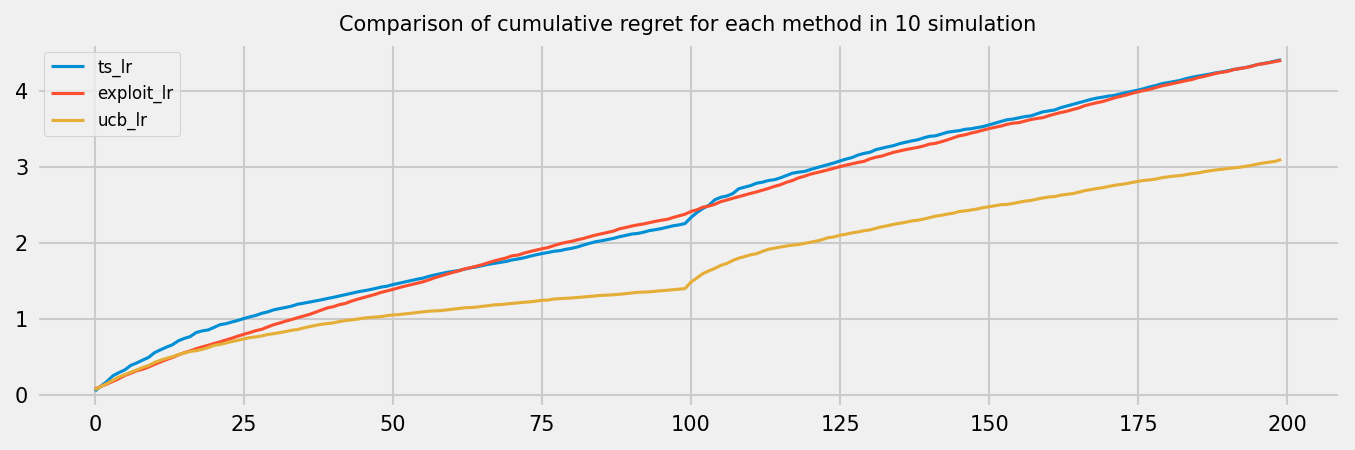

In [86]:
# plot the cumulative regret
plot_regret(regret_mean, n_sims, regret_type='cumulative')

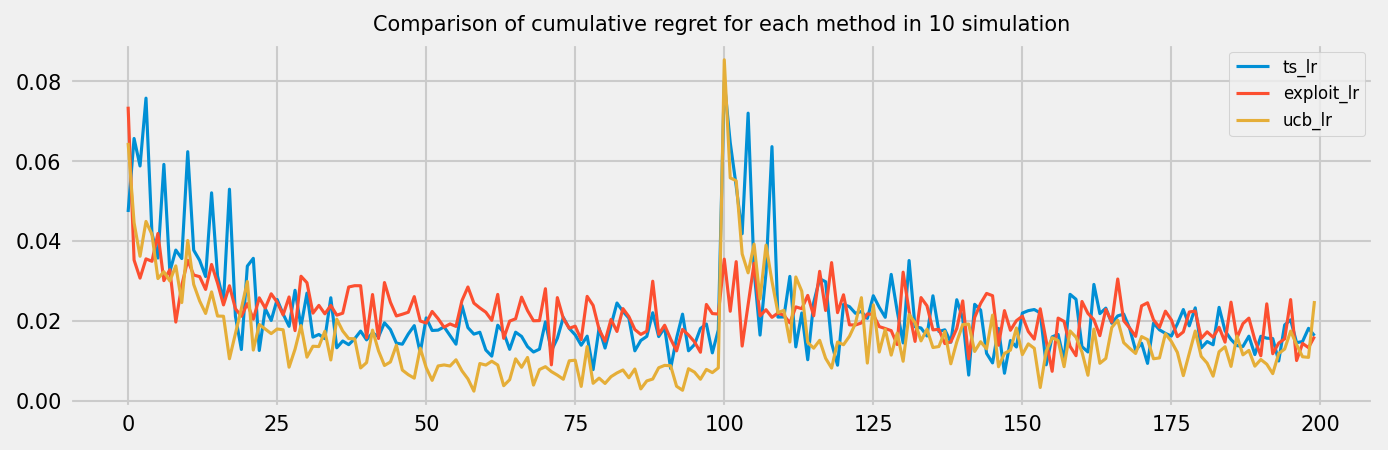

In [87]:
# instant
plot_regret(regret_mean, n_sims, regret_type='instant')

In [88]:
# plot final weights

In [89]:
print(ts_lr.w, ts_lr.m, ts_lr.q)
print(exploit_lr.w, exploit_lr.m, exploit_lr.q)
print(ucb_lr.w, ucb_lr.m, ucb_lr.q)

[ 0.38213347 -1.71614453 -1.2349644 ] [ 0.38213347 -1.71614453 -1.2349644 ] [137.87036653 118.80174474  66.24138497]
[ 0.90510441  2.14445031 -2.87137667] [ 0.90510441  2.14445031 -2.87137667] [110.95846808  92.25300125  38.27482389]
[ 1.28013641  1.58941923 -2.31737298] [ 1.28013641  1.58941923 -2.31737298] [129.65463675 120.12772867  51.19261844]


In [90]:
# get the last round of the last simulation
experiment_df_last_round = experiment_df[(experiment_df['round'] == n_rounds - 1) & (experiment_df['simul_id'] == n_sims - 1)]
experiment_df_last_round.groupby(['policy']).agg({'reward': 'sum', 
                                                   'regret': ['count','sum'],
                                                   'true_weights':'first',
                                                   'sample_weights':'first',
                                                   'mean_weights':'first',
                                                   'std_weights':'first'}).head(10)

reward regret            \
              sum  count       sum   
policy                               
exploit_lr    6.0     10  0.484248   
ts_lr         6.0     10  0.173538   
ucb_lr        7.0     10  0.391455   

                                          true_weights  \
                                                 first   
policy                                                   
exploit_lr  [0.5033463329584329, -0.04775015552187245]   
ts_lr       [0.5033463329584329, -0.04775015552187245]   
ucb_lr      [0.5033463329584329, -0.04775015552187245]   

                                        sample_weights  \
                                                 first   
policy                                                   
exploit_lr     [0.8109857072342905, 2.254086670983911]   
ts_lr       [0.24595926718142444, -1.6090089380290098]   
ucb_lr        [1.2441482041898757, 1.6551482960897939]   

                                         mean_weights  \
                                                first   
policy                                                  
exploit_lr    [0.8109857072342905, 2.254086670983911]   
ts_lr       [0.09381753393264614, -1.708205322048373]   
ucb_lr       [1.2441482041898757, 1.6551482960897939]   

                                         std_weights  
                                               first  
policy                                                
exploit_lr  [60.874411933878186, 47.676497241372445]  
ts_lr        [71.86950950107939, 62.213711886486195]  
ucb_lr        [73.33424022080692, 66.45745801735627]

In [91]:
def plot_weight_distribution(experiment_df_last_round):
    # plot the mean and std of the weights
    plt.close('all')
    plt.figure(figsize=(10, 3), dpi=150)
    # get the final true weights
    true_weights = experiment_df_last_round['true_weights'].values[0]
    for i in range(n_dim):
        plt.figure(figsize=(10, 3), dpi=150)
        m = true_weights[i]
        sigma = 5
        # loop for each decision policy
        for policy in dp_dict.keys():
            X_pdf = np.linspace(m - sigma, m + sigma, 1000)
            online_lr = dp_dict[policy]
            pdf = norm_dist(loc=online_lr.m[i], scale=online_lr.q[i]**(-1.0)).pdf(X_pdf)
            plt.plot(X_pdf, pdf, label=policy, linewidth=1.5)

        # plot a vertical line at the true weights
        plt.axvline(x=m, color='black', linestyle='--', label='True weights', linewidth=1.5)
        plt.xlabel('Weights')
        plt.ylabel('Density') 
        plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)   
    plt.show()

<Figure size 1500x450 with 0 Axes>

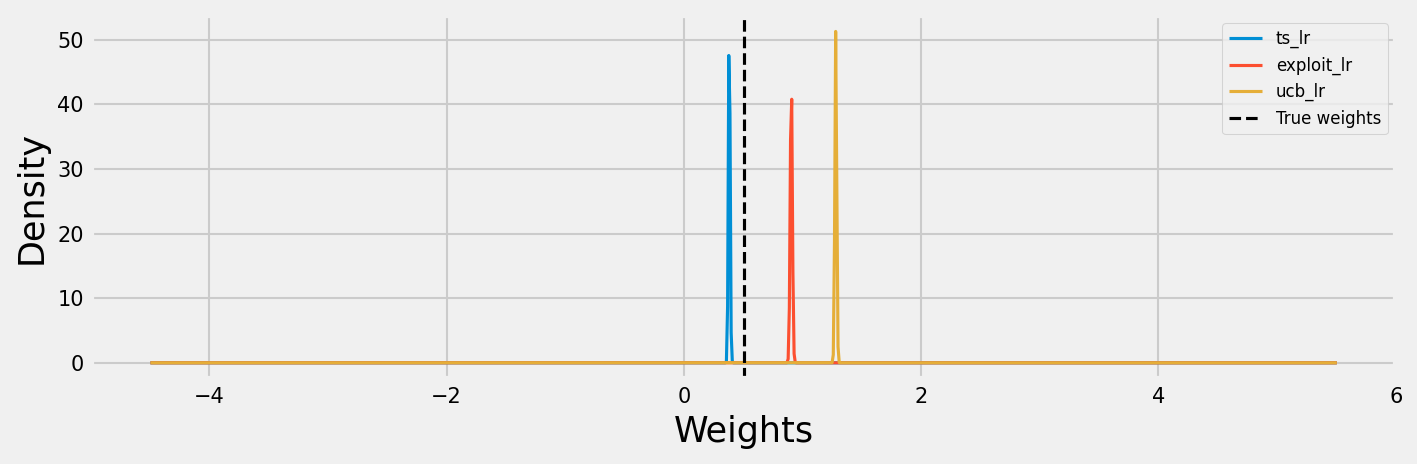

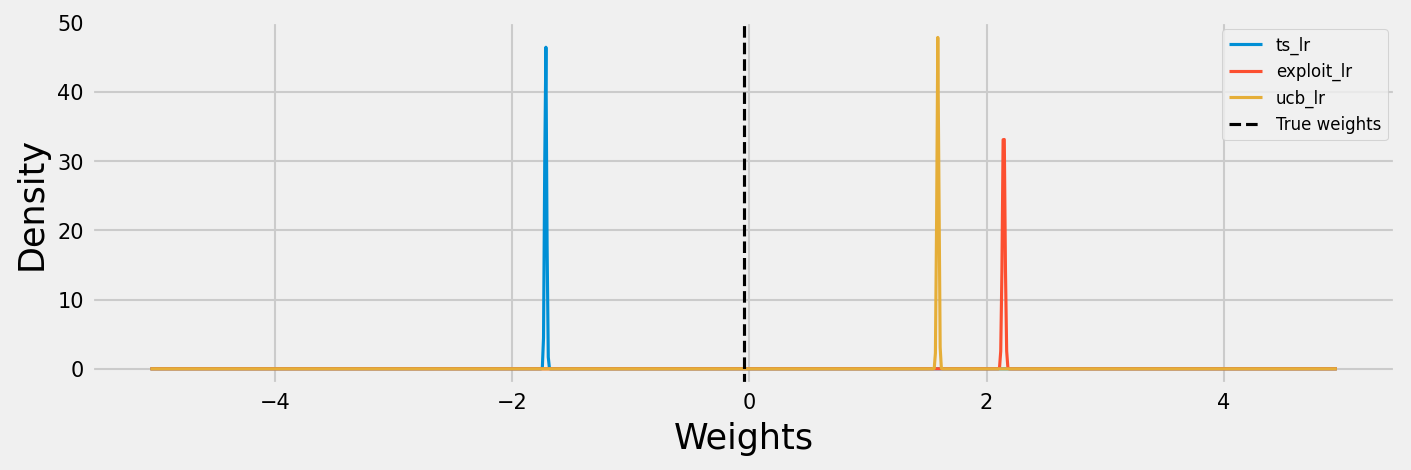

In [92]:
plot_weight_distribution(experiment_df_last_round)

In [93]:
# analyze when running with just 10 data perRound
# load the results from pickle
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = [2,         10,         100,          2,              0.1,        10,          10,         66]
experiment_df = pd.read_pickle(f"../results/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
# our regret calculations
regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()


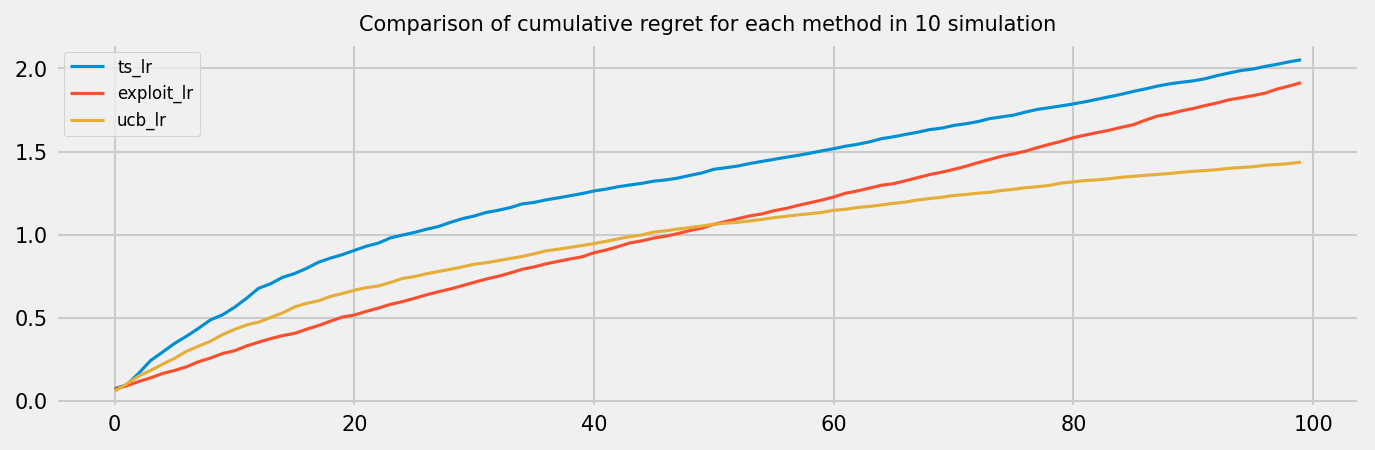

In [94]:
plot_regret(regret_mean, n_sims, regret_type='cumulative')

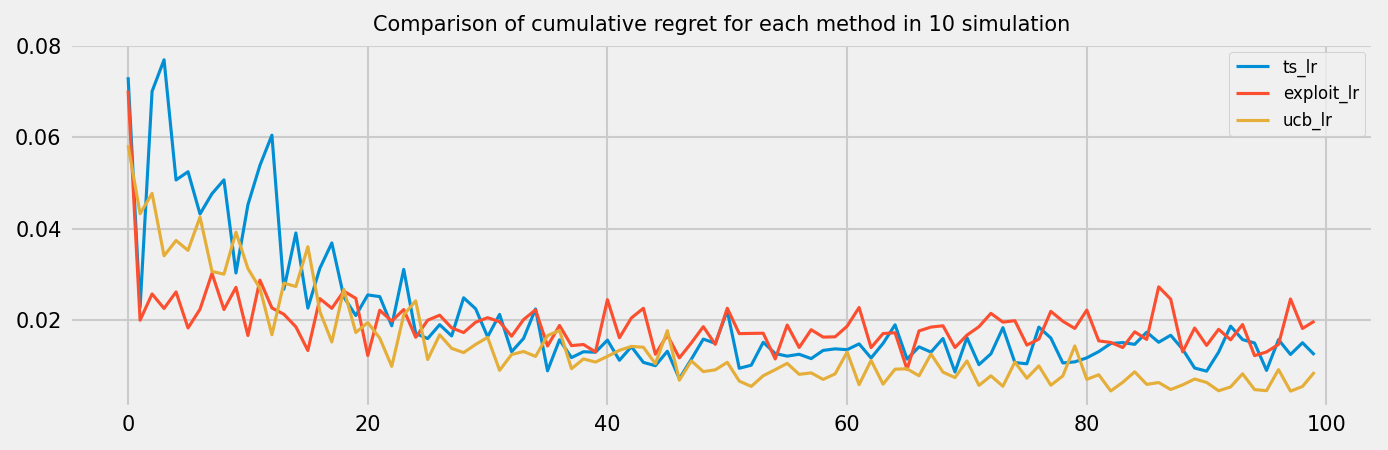

In [95]:
plot_regret(regret_mean, n_sims)

<Figure size 1500x450 with 0 Axes>

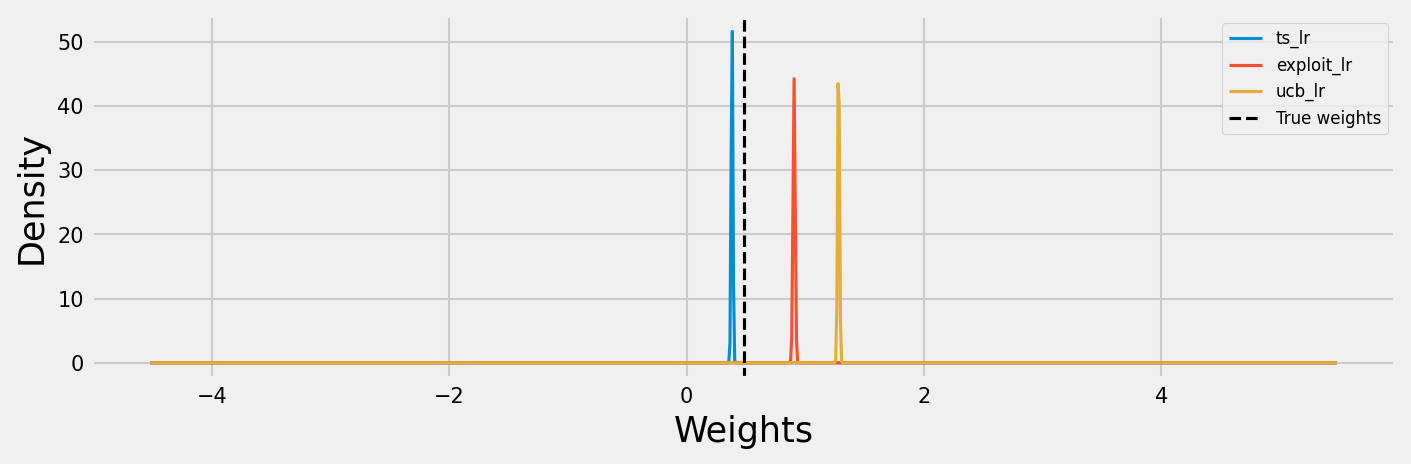

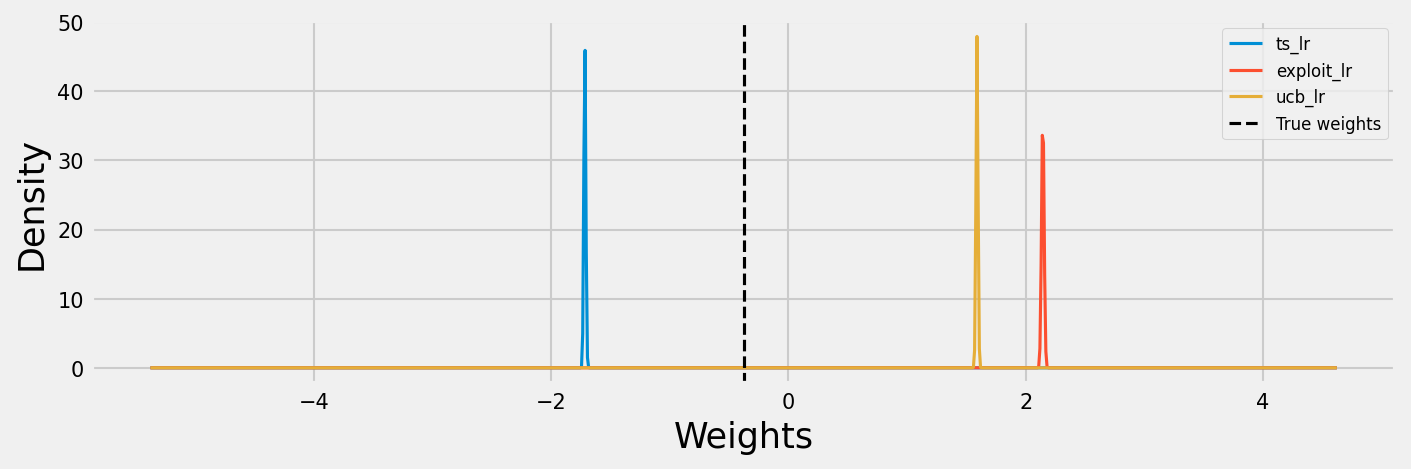

In [96]:
experiment_df_last_round = experiment_df[(experiment_df['round'] == n_rounds - 1) & (experiment_df['simul_id'] == n_sims - 1)]
plot_weight_distribution(experiment_df_last_round)

In [97]:
plot final weights distribution to see if it overlaps.

SyntaxError: expected 'else' after 'if' expression (342037908.py, line 1)

In [ ]:
# try it with multiple parameters:
# parameters:
experiment = 

In [ ]:
plot for 2, 10 features in another notebook

try it with lyra 

simulate new features. 
A system is close to working, get a new feature



In [ ]:
# Sample data with a multi-index
index = pd.MultiIndex.from_tuples([
    ('A', 'foo'),
    ('A', 'bar'),
    ('B', 'foo'),
    ('B', 'bar')
], names=['letter', 'word'])

df = pd.DataFrame({
    'values': [1, 2, 3, 4]
}, index=index)

# Reset the index, which will convert the multi-index levels to columns
df_reset = df.reset_index()

print("DataFrame after reset index:")
print(df_reset)

# Now let's drop the second level's column (level_1)
df_cleaned = df_reset.drop('word', axis=1)

print("\nDataFrame after dropping 'word':")
print(df_cleaned)

DataFrame after reset index:
  letter word  values
0      A  foo       1
1      A  bar       2
2      B  foo       3
3      B  bar       4

DataFrame after dropping 'word':
  letter  values
0      A       1
1      A       2
2      B       3
3      B       4
